# Emergence of Low-level Mathematical Operations in MLPs
# Toy problem B: multi-task networks

In [ ]:
!pip install pacmap

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import os
import random
from collections import OrderedDict
import pacmap

## Global utilities

### Misc

In [2]:
def generate_seed():
    return np.random.randint(1, 2**32 - 1)


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Network

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def print_model_parameters(model):
    for name, param in model.named_parameters():
        print(name, "\n", param.data, "\n")

### Data

In [4]:
# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


def generate_data(n_samples=10000):
    # Epsilon value
    eps = 0.5

    # Initial generation
    Y1 = generate_Y(n_samples)
    X1 = generate_X(Y1, eps)

    # Ensure they are statistically independent by generating new Y and X values
    Y2 = generate_Y(n_samples)
    X2 = generate_X(Y2, eps)

    # Stack X1 and X2 to get the desired shape
    X = torch.cat((X1, X2), dim=1)

    # Stack Y1 and Y2 for the desired shape
    Y = torch.stack((Y1, Y2), dim=1)

    # Validate the relationship
    assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
    assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

    s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

    X_train = X[s_inds[:8000]]
    Y_train = Y[s_inds[:8000]]
    X_valid = X[s_inds[8000:]]
    Y_valid = Y[s_inds[8000:]]

    return X_train, Y_train, X_valid, Y_valid


def plot_data_distribution(X, Y):
    _, ax = plt.subplots()

    ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
    ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
    ax.hist(Y, alpha=0.5, density=True, label="force")
    ax.legend()

### Analysis functions

In [5]:
def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(
                module, input, output, name
            )
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {
        k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2
    }
    return filtered_values

### Training/evaluation

In [6]:
def train(repeats=100, seeds=None):
    if seeds is None:
        seeds = [generate_seed() for _ in range(repeats)]

    rows = []
    for seed in tqdm(seeds):
        set_all_seeds(seed)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~ DATA ~~~~~~~~~~~~~~~~~~~~~~~~~~

        X_train, Y_train, X_valid, Y_valid = generate_data(n_samples=10000)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~~~~~

        n_epochs = 4000  # number of epochs

        model = Net(input_dim=4, hidden_dim=16, output_dim=2)
        loss_func = nn.MSELoss()
        optimiser = Adam(model.parameters(), lr=1e-2)

        for _ in range(n_epochs):
            # Training update
            model.train()
            model.zero_grad()
            Y_hat = model(X_train)
            loss = loss_func(Y_hat, Y_train)
            loss.backward()
            optimiser.step()

            # Validation set
            model.eval()
            Y_hat = model(X_valid)
            loss = loss_func(Y_hat, Y_valid)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~ EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~~~

        res = {}

        N = 5
        pairs = np.concatenate(
            np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
        )
        pairs = pairs.repeat(2, axis=0).reshape(-1, 4)
        pairs = torch.as_tensor(pairs).float()
        outputs = capture_intermediate_outputs(model, pairs)

        res["valid_loss"] = get_valid_loss(model, loss_func, X_valid, Y_valid)
        res["outputs"] = outputs
        res["model"] = model.state_dict()
        res["seed"] = seed

        rows.append(res)

    df = pd.DataFrame(
        rows
    )  # this is ok to fit in memory because our networks are so tiny

    return df


def plot_loss(train_loss, valid_loss, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()
    ax.set_aspect("equal")


def plot_model_performance_summary(model, df, X_valid, Y_valid):
    _, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0] = plot_loss(df["train_loss"], df["valid_loss"], ax=axes[0])

    y_preds, y_targs = get_preds(model, X_valid, Y_valid)
    plot_results(y_preds, y_targs, ax=axes[1])
    axes[1].set_title(
        f"Validation loss: {get_valid_loss(model, nn.MSELoss(), X_valid, Y_valid):.5f}"
    )

## Toy Data

We now have two parallel multiplication tasks. Each is identically distributed but independent from each other.

#### Task A data

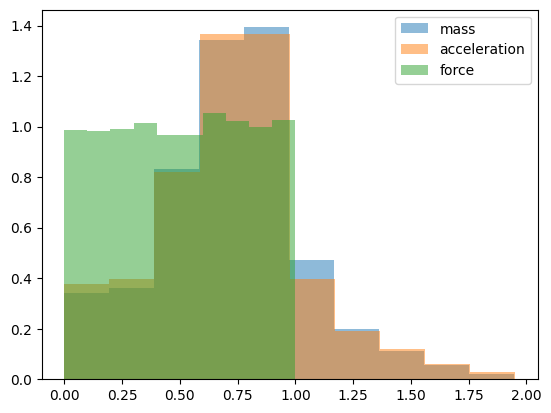

In [7]:
X_train, Y_train, X_valid, Y_valid = generate_data(n_samples=10000)

plot_data_distribution(X_train[:, :2], Y_train[:, 0])

#### Task B data

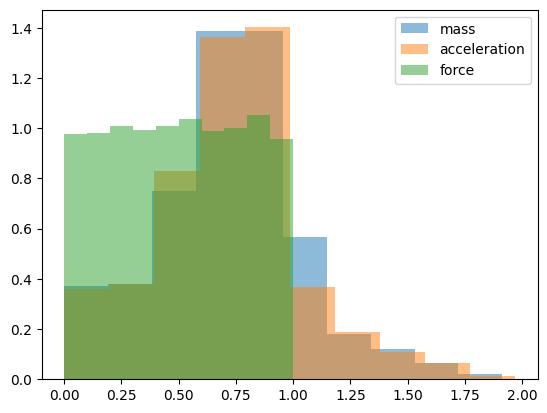

In [8]:
X_train, Y_train, X_valid, Y_valid = generate_data(n_samples=10000)

plot_data_distribution(X_train[:, 2:], Y_train[:, 1])

## Train repeats

We're going to train 100 networks with different data and initialisations so we can produce some nice distributions.

These are small networks so we can fit them all in memory in a nice and neat pandas dataframe.

This training process took < 5 mins on my laptop. Seems more like 15 mins on google colab so feel free to skip if you trust me on the 2 plots below...

In [9]:
seed = 3213569219
set_all_seeds(seed)
seeds = [generate_seed() for _ in range(100)]

df = train(seeds=seeds)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
df["valid_loss"] = df["valid_loss"].apply(lambda x: x.item())

Just to check, we can see that all the networks have trained pretty well. Sufficient for our needs at least:

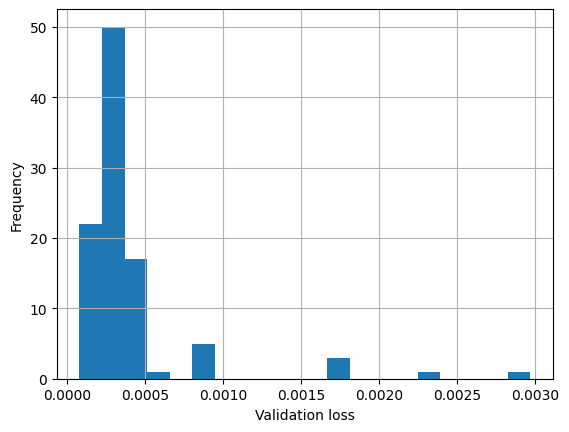

In [11]:
fig, ax = plt.subplots()
df.valid_loss.hist(ax=ax, bins=20)
_ = ax.set(xlabel="Validation loss", ylabel="Frequency")

## Experiments

### Orthogonality in the final linear layer

In [12]:
sims = []
for i, row in df.iterrows():
    lws = row["model"]["layers.1.linear.weight"]
    sim = torch.dot(lws[0], lws[1]) / (torch.norm(lws[0]) * torch.norm(lws[1]))
    sims.append(float(sim))
df["sim"] = sims

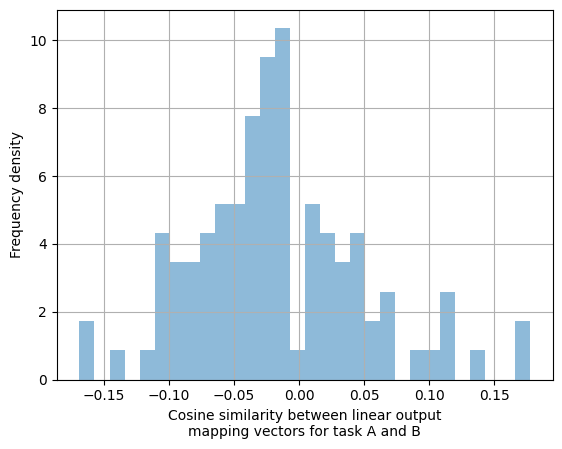

In [13]:
fig, ax = plt.subplots()

df["sim"].hist(alpha=0.5, label="sim", bins=30, ax=ax, density=True)
ax.set(ylabel="Frequency density")
_ = ax.set_xlabel(
    "Cosine similarity between linear output\nmapping vectors for task A and B"
)

We can see that the output vectors are roughly orthogonal suggesting that when we vary the inputs to task A, we traverse a hyperplane orthogonal to the output probe of task B but non-orthogonal to the output probe of task A (vice versa also applies).

### Multi-task activations PCA

Now moving towards a multi-hidden-layer network to see if we can observe task independence in the **intermediate** layers. I've simply added one extra layer to the network.

Here I will be applying PCA to the layer activations in various settings.

#### Helper functions

In [14]:
def get_inputs(N=100, vary_task="A"):
    """Get inputs where one task is varied and the other is fixed."""
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs


def get_pcs(data):
    """Produce principal components and variances for a dataset."""
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances


def get_os(vectors):
    """Get orthogonality scores for a set of vectors."""
    angles = np.arctan2(vectors[..., 1], vectors[..., 0])
    os = np.abs(
        (np.mod(angles, np.pi / 2) - np.pi / 4) / (np.pi / 4)
    )  # I'm sure there's a neater way of doing this...
    return os


class DeeperNet(Net):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

#### Train

In [15]:
N = 4000  # number of epochs
hidden_dim = 16  # number of hidden units

X_train, Y_train, X_valid, Y_valid = generate_data(n_samples=10000)

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [16]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [17]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0004)

Plotting performance for each of the task outputs separately:

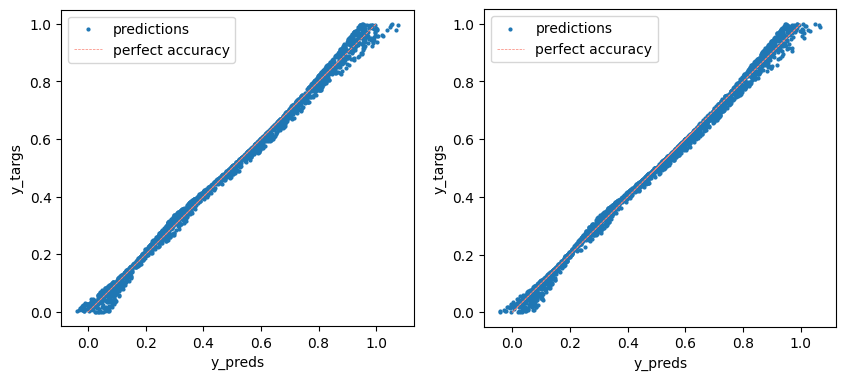

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

#### PCA analysis - combined tasks

First *not* separating out the task datasets for the PCA so we can see what the data looks like combined.

In [19]:
inputs = torch.cat((get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B")))
inputs.shape

torch.Size([20000, 4])

In [20]:
ios = capture_intermediate_outputs(model, inputs)
acts = ios["layers.0.act"]
pcs, vs = get_pcs(acts)  # principal components and variances for both tasks at once
cA = torch.matmul(pcs, acts[:10000].T).T  # task A mappings
cB = torch.matmul(pcs, acts[10000:].T).T  # task B mappings
cA.shape, cB.shape

(torch.Size([10000, 16]), torch.Size([10000, 16]))

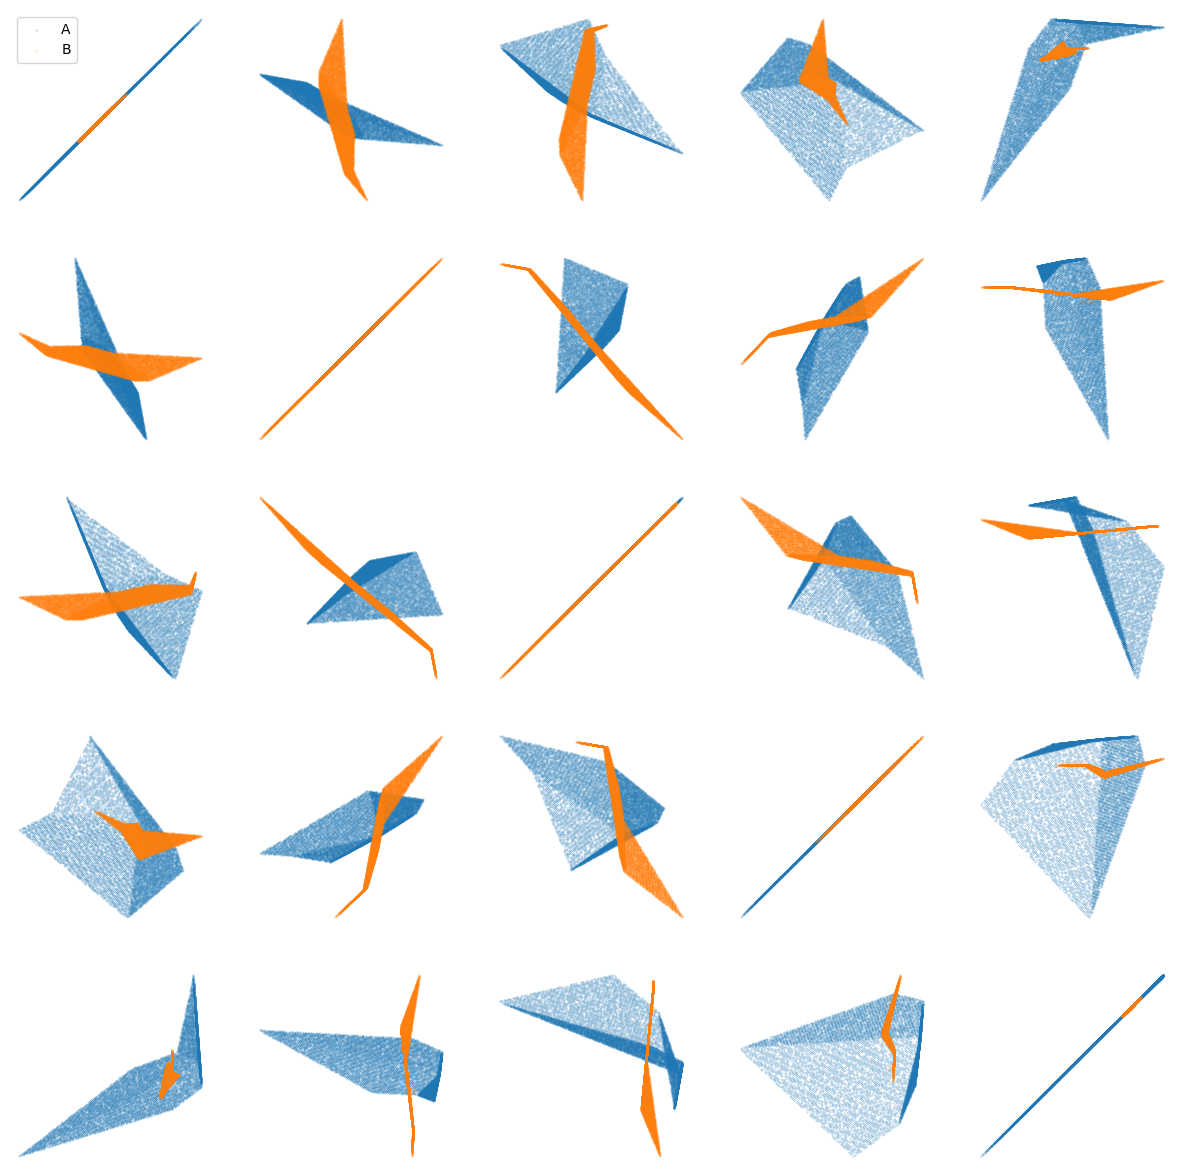

In [21]:
n = 5

fig, axes = plt.subplots(n, n, figsize=(15, 15))

mask = np.random.rand(len(acts) // 2) < 0.8  # make the plot a bit less busy

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.scatter(cA[mask, i], cA[mask, j], alpha=0.5, label="A", s=0.1)
        ax.scatter(cB[mask, i], cB[mask, j], alpha=0.5, label="B", s=0.1)
        ax.axis("off")

_ = axes[0, 0].legend()

Some things to note here:
- these are pretty
- there's redundancy here as the lower triangle is a mirror image of the upper triangle
- the diagonal is not that useful as they're essentially 1D plots
- STILL, they're pretty

Some more useful things to note:
- It's nice to see the unit square input structure propagating through to this layer - we're looking at different projections of it and you can start to make out the structure
- There are little folds at the corners, presumably from the ReLU activations
- I wonder if I should use the heatmaps here too 🤔 might get too busy
- There is separation but also overlap - we'd expect this as there is degeneracy at $(0.5,0.5,0.5,0.5)$ input
- Importantly, I can see some dimensions in which there is large variance in one of the tasks and small variance in the others - suggesting some independence
- I will move from this graphical representation to something more quantifiable

I'm going to try PACMAP just for laughs (although the dimensions are somewhat less meaningful):

In [22]:
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)

# fit the data (The index of transformed data corresponds to the index of the original data)
acts_transformed = embedding.fit_transform(acts.numpy(), init="pca")

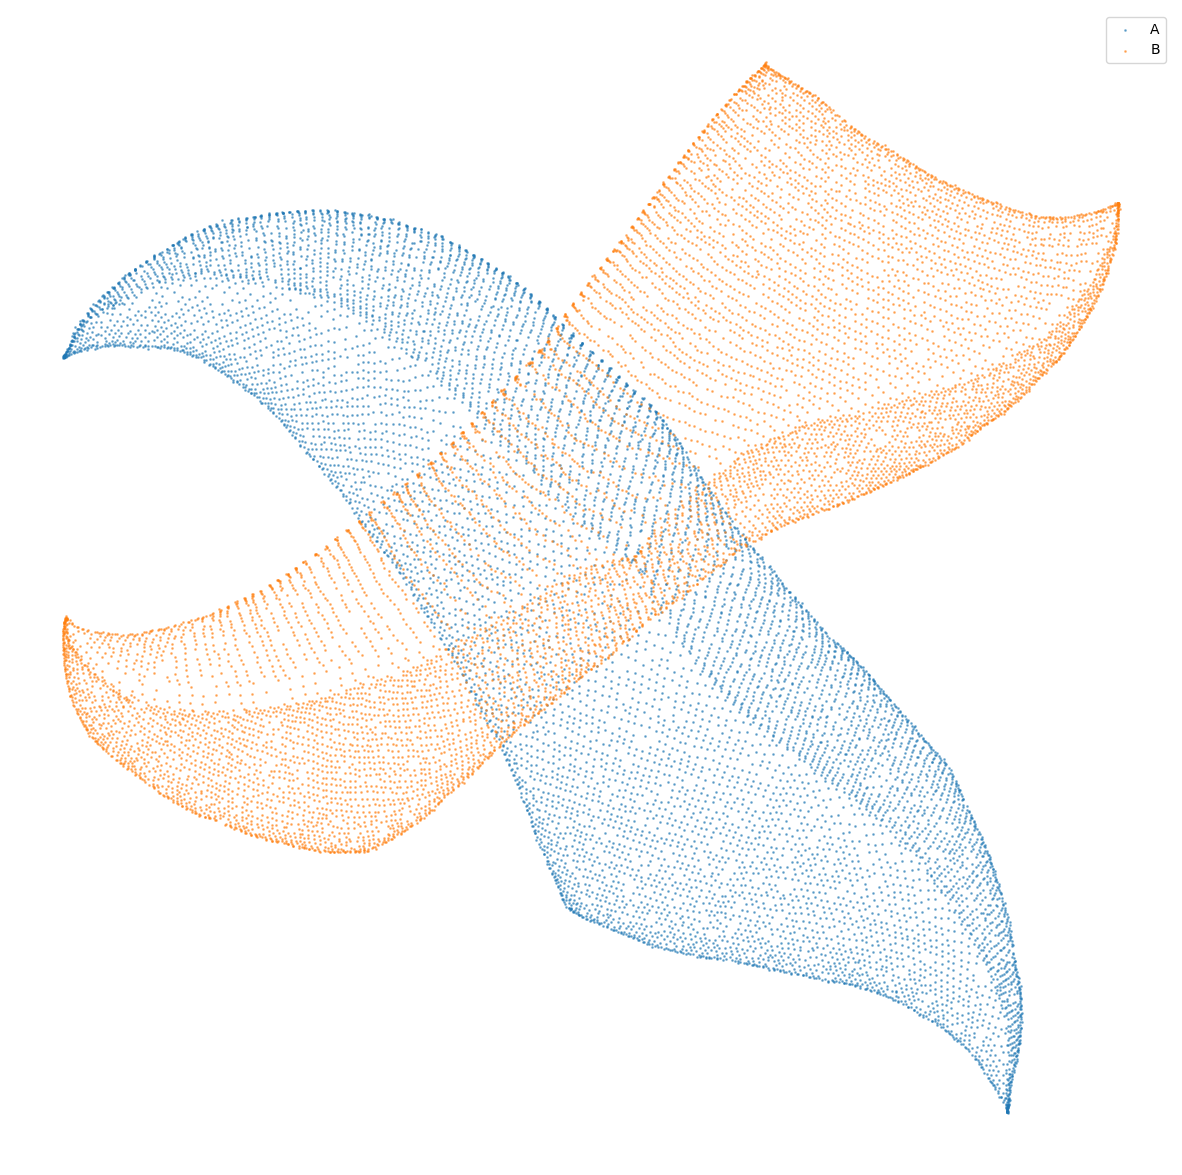

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))

mask = np.random.rand(len(acts) // 2) < 0.9

ax.scatter(*acts_transformed[:10000][mask].T, alpha=0.5, label="A", s=1)
ax.scatter(*acts_transformed[10000:][mask].T, alpha=0.5, label="B", s=1)
ax.axis("off")

_ = ax.legend()

Yeah there's never _loads_ we can say from these heavy dimensionality reductions but it seems like there's something task-separated going on here... 

#### PCA analysis - tasks separated

Now applying the PCA to the activations for each task-varying dataset separately.

In [24]:
pcsA, vsA = get_pcs(acts[:10000])
pcsB, vsB = get_pcs(acts[10000:])

sims = torch.matmul(
    pcsA.T, pcsB
)  # I'm pretty sure this is correct from the orientations of the principal components
sims = sims.numpy()

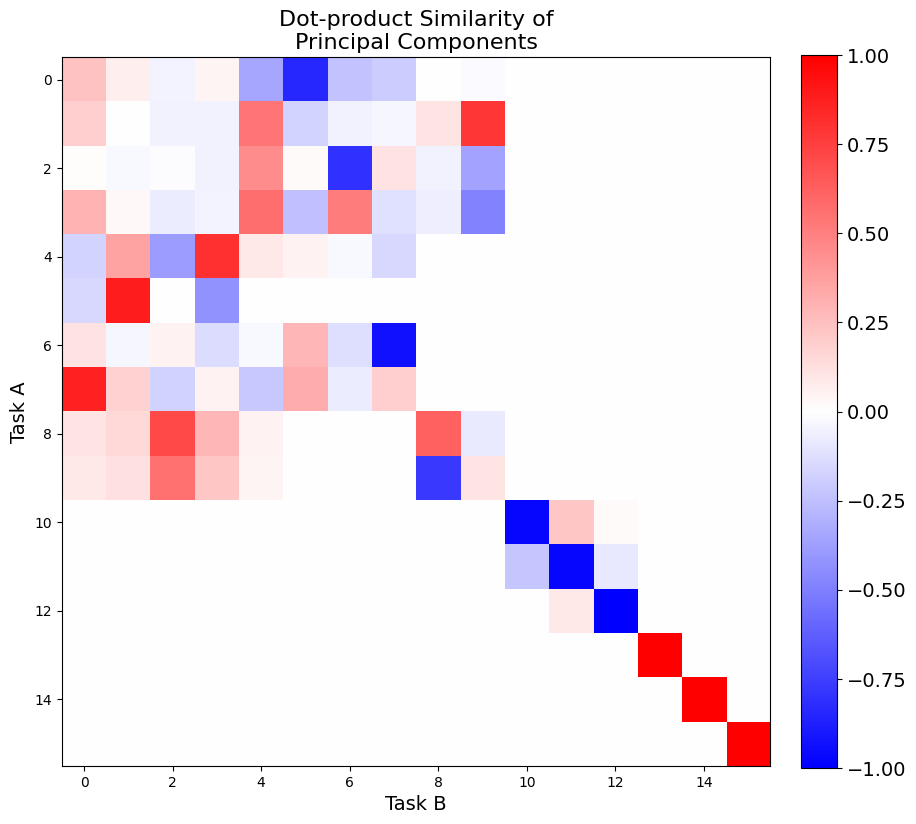

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)

ax.set_title("Dot-product Similarity of\nPrincipal Components", fontsize=16)
ax.set_xlabel("Task B", fontsize=14)
_ = ax.set_ylabel("Task A", fontsize=14)

I haven't fully understood the implications of this plot yet but here are some thoughts:
- the high variance components for both tasks (at low component index number in the top left) have quite small dot products suggesting they are roughly orthogonal. This means that there is less interference between the components which seem to matter most for each task, suggesting orthogonal task treatment.
- There are even more orthogonal task vectors between the high and low variance components for each task (bottom left and top right). I'm not sure what to make of this. I'm also not sure why there is such a sudden drop off in dot product similarity as we look at the lower variance components. This would be interesting to understand.
- I'm not sure what's going on in the bottom right corner.

Now I'd like to bring the actual magnitude of the variance into the picture since it doesn't matter if components are non-orthogonal unless they're truly high-variance in both tasks. The similarity matrix above provides a variance _rank_ but I'd like the actual absolute value of the variance.

In [26]:
# Get variances for each principal component against each task
varAA = [torch.var((pcsA[:, i] * acts[:10000]).sum(-1)) for i in range(16)]
varBA = [torch.var((pcsB[:, i] * acts[:10000]).sum(-1)) for i in range(16)]
varBB = [torch.var((pcsB[:, i] * acts[10000:]).sum(-1)) for i in range(16)]
varAB = [torch.var((pcsA[:, i] * acts[10000:]).sum(-1)) for i in range(16)]

# Stack the variances into a matrix
dataA = torch.stack((torch.stack(varAB), torch.stack(varAA))).T
dataB = torch.stack((torch.stack(varBA), torch.stack(varBB))).T

mags = []
orthos = []
for data in [dataA, dataB]:
    mags.append(np.linalg.norm(data, axis=1))  # magnitude of the variance vectors
    orthos.append(get_os(data))  # orthogonality scores of the variance vectors

mags = np.concatenate(mags)
orthos = np.concatenate(orthos)

mags.shape, orthos.shape

((32,), (32,))

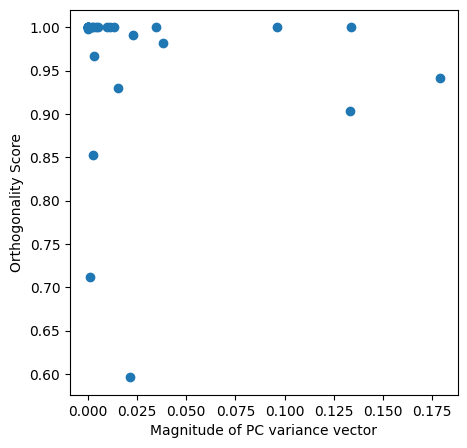

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(mags, orthos)
ax.set_xlabel("Magnitude of PC variance vector")
_ = ax.set_ylabel("Orthogonality Score")

Some points here:
- the "orthogonality score" is essentially how close to $0$ or $\frac{\pi}{2}$ the angle between the variances for each task mapped onto a principal component is
- the "Magnitude of PC variance vector" is the magnitude of the 2D vector produced by these mapped variances

The points roughly follow the nice right angle distribution we'd expect for orthogonally treated tasks.

In retrospect, I wonder if what I was really interested in was a covariance matrix here?

In [28]:
data = torch.cat((dataA, dataB))
torch.cov(data.T)

tensor([[ 8.1549e-04, -4.7791e-05],
        [-4.7791e-05,  1.5168e-03]])

Alternatively, we can look at the variance explained:

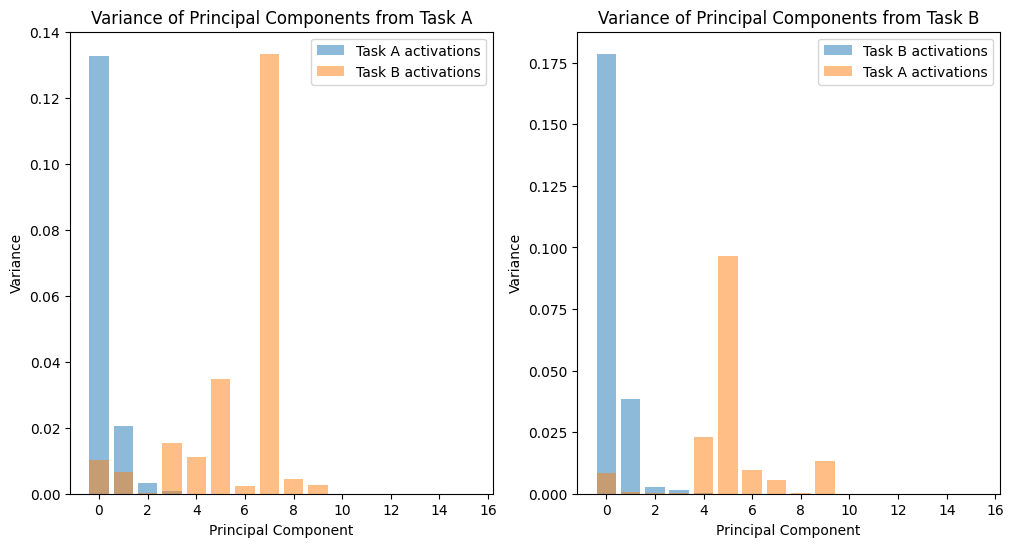

In [29]:
def plot_pca_variances(varAA, varAB, varBA, varBB):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot the variances for task A
    axs[0].bar(range(len(varAA)), varAA, label="Task A activations", alpha=0.5)
    axs[0].bar(range(len(varBA)), varAB, label="Task B activations", alpha=0.5)
    axs[0].set_xlabel("Principal Component")
    axs[0].set_ylabel("Variance")
    axs[0].set_title("Variance of Principal Components from Task A")
    axs[0].legend()

    # plot the variances for task B
    axs[1].bar(range(len(varAA)), varBB, label="Task B activations", alpha=0.5)
    axs[1].bar(range(len(varBA)), varBA, label="Task A activations", alpha=0.5)
    axs[1].set_xlabel("Principal Component")
    axs[1].set_ylabel("Variance")
    axs[1].set_title("Variance of Principal Components from Task B")
    axs[1].legend()

    plt.show()


plot_pca_variances(varAA, varAB, varBA, varBB)

This fits in nicely with the similarity matrix where we can see that there are roughly three main classes of component:
1. The high variance, low-interference components on the left of the plot
2. The lower variance, low-interference components in the centre
3. The almost zero variance, but saturated interference components on the right

Intuitively, group 2 in the left plot must be somewhat aligned with group 1 on the right and vice versa. I haven't _quite_ internalised the significance of this plot, but I'd hypothesise that group 1 are the important dimensions that are accessed and that the others aren't typically "used" by the next layer. It seems to me that the other groups are somewhat randomly distributed in the space remaining after the important variance is captured, therefore they capture a spread of the alternative task's variance. This would be interesting to test.